In [4]:
%matplotlib inline

import os
import sys


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

In [5]:
# Read counts
adata = sc.read_csv("delile_data/counts.csv")

# Transpose adata
adata = adata.transpose()

In [6]:
# Read phenoData
pheno = pd.read_table('delile_data/phenoData_annotated.tsv', sep='\t')
pheno = pheno.rename(columns={'Unnamed: 0':'barcode'})
pheno = pheno[['barcode', 'timepoint', 'Type_step1', 'Type_step2']]

# Add annotation data to adata 
adata.obs = adata.obs.merge(pheno, how='inner', left_index=True, right_on='barcode')

# Subset for motor neurons 
adata = adata[(adata.obs.Type_step2 == 'pMN') | (adata.obs.Type_step2 == 'MN')]

... storing 'Type_step1' as categorical
... storing 'Type_step2' as categorical


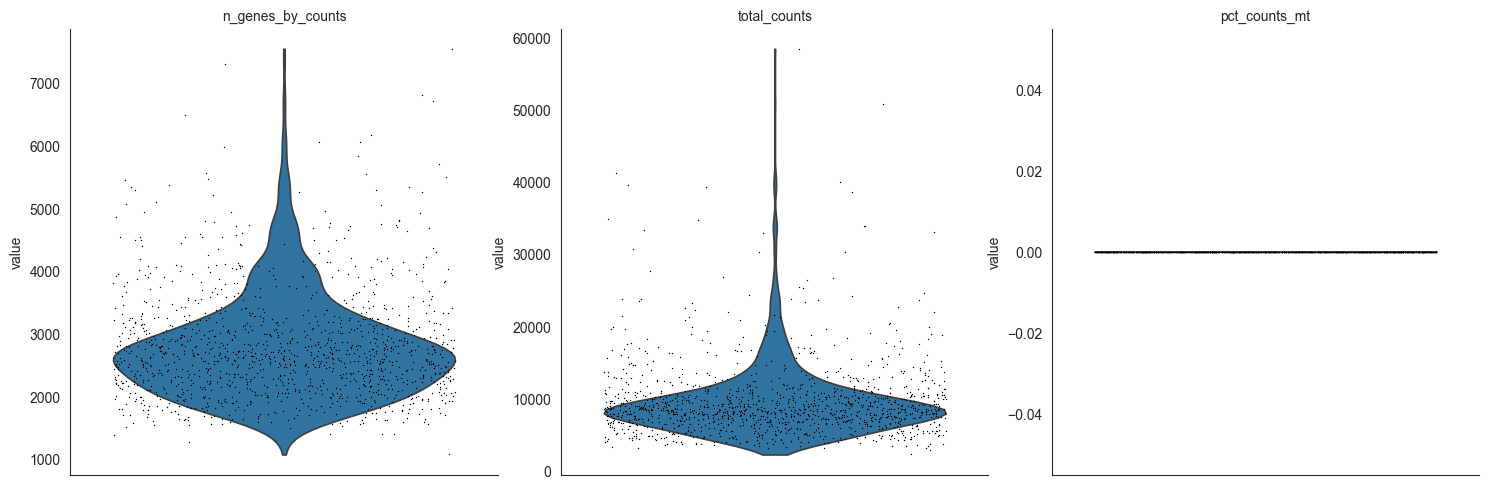

In [7]:
# Plot quality metrics, mitochondrial counts were preprocessed 
adata.var["mt"] = adata.var_names.str.startswith("Mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars = ["mt"], inplace=True, log1p = True)

sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

In [8]:
# Save copy of raw data
adata.layers['counts'] = adata.X.copy()

In [9]:
# Preprocessing, count normalization
adata.obs.index = adata.obs.index.astype(str)
sc.pp.filter_cells(adata, min_counts=200)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_per_cell(adata, key_n_counts='n_counts_all')

In [10]:
# Calculate highly variable genes
filter_result = sc.pp.filter_genes_dispersion(adata.X,
                                              flavor='cell_ranger',
                                              n_top_genes=2000,
                                              log=False)

# Subset features to highly variable genes
adata = adata[:, filter_result.gene_subset]

# Renormalize 
sc.pp.normalize_per_cell(adata)

In [11]:
# Log transformation and scaling
sc.pp.log1p(adata)
sc.pp.scale(adata)

In [12]:
# PCA
sc.tl.pca(adata, svd_solver='arpack')

# Diffusion map
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.diffmap(adata)

# Calculate neighbors again based on diffusion map
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')

# Leiden clustering 
sc.tl.leiden(adata, resolution=0.1)

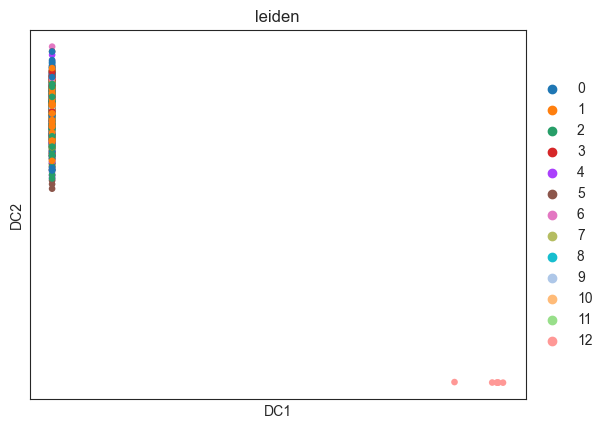

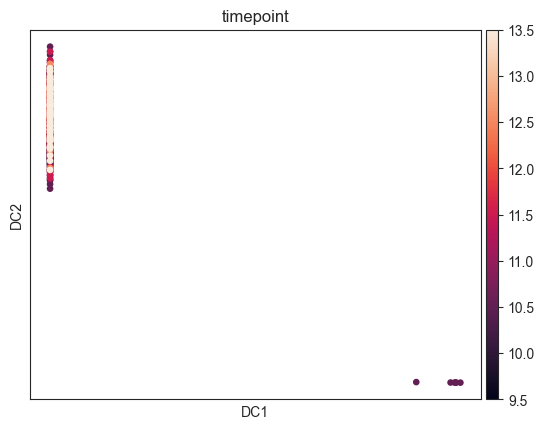

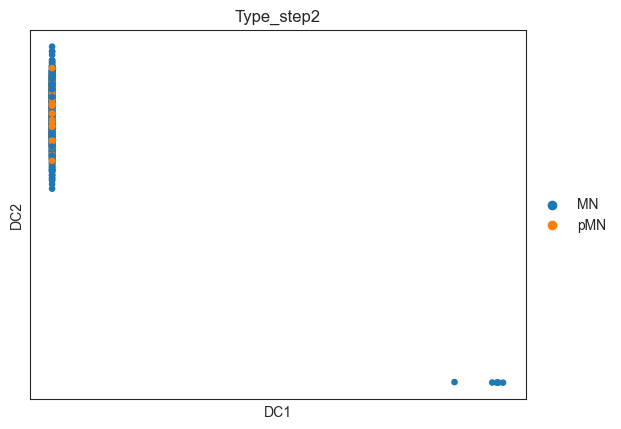

In [13]:
# Plot diffusion maps
sc.pl.diffmap(adata, color=f'leiden')
sc.pl.diffmap(adata, color='timepoint')
sc.pl.diffmap(adata, color='Type_step2')

In [15]:
adata.write_h5ad("intermediate_data/1_delile.h5ad")